## AIM: Validate preprocessing method(s) by checking performance on EC/EO classification

OLD VERSION: THIS STILL INCLUDED ALL TRIED PREPROCESSING METHODS + THE OLD CHANNEL GROUPINGS

First, seperate dataframes will be made for the different preprocessing methods (no preprocessing, Van Dijk preprocessing, own preprocessing).
These dataframes will contain calculated PSDs for alpha, beta, delta, gamma, and theta frequency bands for 4 groups of channels (frontal, central, parietal, occipital)
These dataframes will then be used to train a classification model that predicts EC/EO condition. Model performance will be evaluated for validating the preprocessing methods.

Conclusion:

The non-preprocessed data actually performs the best, but it is expected that this is due to eye-blink artifacts in the EO condition not being filtered out.
The next best performing preprocessing pipeline is the method described by Van Dijk. For now, we will continue with these preprocessed data, but might compare performances again at a later stage. It is not sure how reliable & insightful this method of measurement is for assessing the quality of preprocessing methods. Fortunately, either way the data does still result in a decently high accuracy (~75%) in predicting the EO/EO condition.

In [10]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import mne
import os
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

In [7]:
# set folder to store the data as working directory
working_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\EC_EO_classification"
os.chdir(working_dir)
os.getcwd()

'D:\\Documents\\RU\\Master_Neurobiology\\Internship_jaar_2\\Project\\TD-BRAIN\\EC_EO_classification\\TDBRAIN_prep'

### Loading in participants data

In this case, discovery/replication group does not have to be split, because for all participants we know the EC/EO condition

In [9]:
# The output from this notebook is computed with a dataframe at the start of the internship that still contained the replication set as well.
# If you would rerun this notebook now, the 'df_participants.pkl' file will only contain the discovery set.
# All the calculations will however be the same and it should not have a large effect on the results, as the replication set in this case also includes the classes (EC/EO),
# the only difference is the sample size.
# So we will not rerun this notebook for the current project for time reasons.
# Either way, to include the replication set and in turn obtain the exact same results as in the output from this notebook:
# We can load the 'TDBRAIN_participants_V2.tsv' file as 'df_participants' with pd.read_csv(), instead of 'df_participants.pkl' and run the code below.
df_participants = pd.read_pickle('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data\df_participants.pkl')
print(df_participants.shape)
df_participants.sample(5)

(1347, 11)


,participants_ID,DISC/REP,indication,formal_status,Dataset,age,gender,sessID,nrSessions,EC,EO
108,sub-19734439,REPLICATION,REPLICATION,REPLICATION,REPLICATION,30.00,0,1,1,True,True
674,sub-88024561,DISCOVERY,ADHD/ASD/ANXIETY,UNKNOWN,NaN,11.93,1,1,1,True,True
38,sub-19703068,REPLICATION,REPLICATION,REPLICATION,REPLICATION,29.26,0,1,1,True,True
1345,sub-88078837,DISCOVERY,INSOMNIA,INSOMNIA,NaN,24.63,1,1,1,True,True
1270,sub-88073565,DISCOVERY,NaN,UNKNOWN,NaN,16.37,0,1,1,True,True


### Creating montage and info object for PSD calculation with MNE

In [11]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }

# channel groupings
frontal = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4']
central = ['T7', 'C3', 'Cz', 'C4', 'T8']
parietal = ['CP3','CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8'] 
occipital = ['O1', 'Oz', 'O2']
channel_groups = {'frontal': frontal, 'central': central, 'parietal': parietal, 'occipital': occipital}

# define upper and lower frequencies for each band
delta = [1, 4] # starting at one because of high-pass filter
theta = [4, 8]
alpha = [8, 12]
beta = [12, 30]
gamma = [30, 100] 
bands = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}


## Create montage
montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')

# Create info object for MNE
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG, 5 EOG, 1 ECG, 1 EMG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>


### 1. Unprocessed data

In [68]:
# calculate PSD for each file and store in dataframe
eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives"
exlude_dirs = ['preprocessed', 'results_manuscript', 'adhd_sample'] # exclude these directories

#sample_ids = ['sub-19681349'] # list of participants to include
df_unprocessed = pd.DataFrame() # create empty dataframe to store PSD data

# counter for progress
count = 1
if count == 1:
    total_files = 0
    for _, dirs, files in os.walk(eeg_dir):
        dirs[:] = [d for d in dirs if d not in exlude_dirs] # exclude directories
        total_files += len(files)

for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    dirs[:] = [d for d in dirs if d not in exlude_dirs] # exclude directories
    for file in files:
        #if any(sample_id in file for sample_id in sample_ids): # filter participants to include
            if 'ses-1' in file: # filter first session
                filepath = os.path.join(subdir, file) # path to eeg file

                eeg_data = pd.read_csv(filepath, sep=',')
                eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

                raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
                raw.notch_filter(50) # only preprocessing step is notch filter,
                raw.filter(1, 100) # and BP filter

                # epoch the data
                epochs = mne.make_fixed_length_epochs(raw, duration = 9.95, overlap = 0)

                if 'EC' in file:
                    cond = 0
                if 'EO' in file:
                    cond = 1

                # add data to empty dictionary
                psd_dict = {}
                psd_dict['ID'] = [file.split('_')[0]] * epochs.get_data().shape[0]
                psd_dict['EO/EC'] = [cond] * epochs.get_data().shape[0]
                psd_dict['epoch'] = list(range(1, epochs.get_data().shape[0] + 1))
                
                # calculate PSD using Welch's method for each freq band and channel group
                for band in bands:
                    for group in channel_groups:
                        psd_epochs = epochs.compute_psd(method = 'welch', fmin = bands[band][0], fmax = bands[band][1], picks = channel_groups[group], average = 'mean')

                        # compute average spectral spower per epoch per channel group
                        psd_mean = psd_epochs.get_data().mean(axis = (2, 1))

                        psd_dict[f'{group}_{band}'] = psd_mean # add to dictionary
                
                # add to dataframe
                df_unprocessed = pd.concat([df_unprocessed, pd.DataFrame(psd_dict)], ignore_index = True)

                print(f'\rProgress: {count}/{total_files} files processed.', end = '')
                count += 1
                
df_unprocessed.shape


Progress: 2518/2694 files processed.

(30221, 23)

In [ ]:
print(df_unprocessed.shape)
df_unprocessed.tail(5)

In [69]:
df_unprocessed.to_pickle('df_unprocessed_psds.pkl')

### 2. Van Dijk's preprocessed data

In [81]:
# calculate PSD for each file and store in dataframe
eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\preprocessed"

#exlude_dirs = ['preprocessed', 'results_manuscript', 'adhd_sample'] # exclude these directories
#sample_ids = ['sub-19681349'] # list of participants to include

df_vandijk = pd.DataFrame() # create empty dataframe to store PSD data

# counter for progress
count = 1
if count == 1:
    total_files = 0
    for _, dirs, files in os.walk(eeg_dir):
        #dirs[:] = [d for d in dirs if d not in exlude_dirs] # exclude directories
        total_files += len([file for file in files if '.npy' in file])

for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    #dirs[:] = [d for d in dirs if d not in exlude_dirs] # exclude directories
    for file in files:
        #if any(sample_id in file for sample_id in sample_ids): # filter participants to include
            if 'ses-1' in file and '.npy' in file: # filter first session & .npy files
                filepath = os.path.join(subdir, file) # path to eeg file

                # needs specific info object, because has one less channel
                info = mne.create_info(ch_names=ch_names[:32], ch_types=ch_types[:32], sfreq=500)
                info.set_montage(montage=montage, on_missing= 'raise')

                preprocessed_eeg = np.load(filepath, allow_pickle = True)
                raw = mne.io.RawArray(np.squeeze(preprocessed_eeg['data']), info)

                # epoch the data
                epochs = mne.make_fixed_length_epochs(raw, duration = 9.95, overlap = 0)

                if 'EC' in file:
                    cond = 0
                if 'EO' in file:
                    cond = 1

                # add data to empty dictionary
                psd_dict = {}
                psd_dict['ID'] = [file.split('_')[0]] * epochs.get_data().shape[0]
                psd_dict['EO/EC'] = [cond] * epochs.get_data().shape[0]
                psd_dict['epoch'] = list(range(1, epochs.get_data().shape[0] + 1))
                
                # calculate PSD using Welch's method for each freq band and channel group
                for band in bands:
                    for group in channel_groups:
                        psd_epochs = epochs.compute_psd(method = 'welch', fmin = bands[band][0], fmax = bands[band][1], picks = channel_groups[group], average = 'mean')

                        # compute average spectral spower per epoch per channel group
                        psd_mean = psd_epochs.get_data().mean(axis = (2, 1))

                        psd_dict[f'{group}_{band}'] = psd_mean # add to dictionary
                
                # add to dataframe
                df_vandijk = pd.concat([df_vandijk, pd.DataFrame(psd_dict)], ignore_index = True)

                print(f'\rProgress: {count}/{total_files} files processed.', end = '')
                count += 1
                
df_vandijk.shape
df_vandijk.tail(3)


Progress: 2518/2692 files processed.

,ID,EO/EC,epoch,frontal_delta,central_delta,parietal_delta,occipital_delta,frontal_theta,central_theta,parietal_theta,...,parietal_alpha,occipital_alpha,frontal_beta,central_beta,parietal_beta,occipital_beta,frontal_gamma,central_gamma,parietal_gamma,occipital_gamma
30218,sub-88079017,1,10,6.498310,4.875954,3.837009,2.177845,2.358043,1.617804,1.544297,...,4.045533,3.671333,0.459430,0.373394,0.534844,0.810811,0.148447,0.105986,0.103025,0.404294
30219,sub-88079017,1,11,6.391118,6.016342,4.744966,3.258825,2.931342,2.121927,1.990200,...,6.133334,6.877538,0.484723,0.440534,0.682482,0.932327,0.161340,0.115961,0.110986,0.434993
30220,sub-88079017,1,12,4.534278,3.599533,3.119926,2.482180,1.905372,1.724762,2.037364,...,5.210649,3.230380,0.589229,0.548537,0.836876,1.011793,0.178985,0.135413,0.120101,0.451444


In [82]:
print(df_vandijk.shape)

(30221, 23)


In [83]:
df_vandijk.to_pickle('df_vandijk_psds.pkl')

### 3. Our own preprocessed data

In [ ]:
# set folder with module for own preprocessed class as working directory for importing modules
working_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\EC_EO_classification\TDBRAIN_prep"
os.chdir(working_dir)
os.getcwd()

from preprocess_pipeline import preprocess_pipeline # our own module for preprocessing, which is needed to load the data

'D:\\Documents\\RU\\Master_Neurobiology\\Internship_jaar_2\\Project\\TD-BRAIN\\EC_EO_classification\\TDBRAIN_prep'

In [12]:
# calculate PSD for each file and store in dataframe
eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\preprocessed_own"

#exlude_dirs = ['preprocessed', 'results_manuscript', 'adhd_sample'] # exclude these directories
#sample_ids = ['sub-87971373'] # list of participants to include

df_own = pd.DataFrame() # create empty dataframe to store PSD data

# counter for progress
count = 1
if count == 1:
    total_files = 0
    for _, dirs, files in os.walk(eeg_dir):
        #dirs[:] = [d for d in dirs if d not in exlude_dirs] # exclude directories
        total_files += len([file for file in files if '.npy' in file])

for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    #dirs[:] = [d for d in dirs if d not in exlude_dirs] # exclude directories
    for file in files:
        #if any(sample_id in file for sample_id in sample_ids): # filter participants to include
            if 'ses-1' in file and '.npy' in file: # filter first session & .npy files
                filepath = os.path.join(subdir, file) # path to eeg file

                #info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
                #info.set_montage(montage=montage, on_missing= 'raise')

                preprocessed_eeg = np.load(filepath, allow_pickle = True)
                raw = preprocessed_eeg.preprocessed_raw

                # epoch the data
                epochs = mne.make_fixed_length_epochs(raw, duration = 9.95, overlap = 0)

                if 'EC' in file:
                    cond = 0
                if 'EO' in file:
                    cond = 1

                # add data to empty dictionary
                psd_dict = {}
                psd_dict['ID'] = [file.split('_')[0]] * epochs.get_data().shape[0]
                psd_dict['EO/EC'] = [cond] * epochs.get_data().shape[0]
                psd_dict['epoch'] = list(range(1, epochs.get_data().shape[0] + 1))
                
                # calculate PSD using Welch's method for each freq band and channel group
                for band in bands:
                    for group in channel_groups:
                        try: # have to try, incase there are not enough good channels in a group
                            psd_epochs = epochs.compute_psd(method = 'welch', fmin = bands[band][0], fmax = bands[band][1], picks = channel_groups[group], average = 'mean')
                            # compute average spectral spower per epoch per channel group
                            psd_mean = psd_epochs.get_data().mean(axis = (2, 1))

                        except: # if not enough good channels in group, set to NaN
                            print(f'\nnot enough good channels in {group = } for {file = }, setting {group}_{band} to NaN')
                            psd_mean = np.nan

                        psd_dict[f'{group}_{band}'] = psd_mean # add to dictionary
                
                # add to dataframe
                df_own = pd.concat([df_own, pd.DataFrame(psd_dict)], ignore_index = True)

                print(f'\rProgress: {count}/{total_files} files processed.', end = '')
                count += 1
                
print('\n', df_own.shape)
df_own.tail(3)


Progress: 392/2518 files processed.
not enough good channels in group = 'occipital' for file = 'sub-87971373_ses-1_task-restEC_preprocessed.npy', setting occipital_delta to NaN

not enough good channels in group = 'occipital' for file = 'sub-87971373_ses-1_task-restEC_preprocessed.npy', setting occipital_theta to NaN

not enough good channels in group = 'occipital' for file = 'sub-87971373_ses-1_task-restEC_preprocessed.npy', setting occipital_alpha to NaN

not enough good channels in group = 'occipital' for file = 'sub-87971373_ses-1_task-restEC_preprocessed.npy', setting occipital_beta to NaN

not enough good channels in group = 'occipital' for file = 'sub-87971373_ses-1_task-restEC_preprocessed.npy', setting occipital_gamma to NaN
Progress: 632/2518 files processed.
not enough good channels in group = 'occipital' for file = 'sub-88008137_ses-1_task-restEC_preprocessed.npy', setting occipital_delta to NaN

not enough good channels in group = 'occipital' for file = 'sub-88008137_ses-1

,ID,EO/EC,epoch,frontal_delta,central_delta,parietal_delta,occipital_delta,frontal_theta,central_theta,parietal_theta,...,parietal_alpha,occipital_alpha,frontal_beta,central_beta,parietal_beta,occipital_beta,frontal_gamma,central_gamma,parietal_gamma,occipital_gamma
30218,sub-88079017,1,10,0.026931,0.037145,0.030944,0.016313,0.011151,0.013540,0.011232,...,0.019604,0.018681,0.004819,0.007210,0.006840,0.006146,0.002710,0.003787,0.002739,0.003831
30219,sub-88079017,1,11,0.032124,0.044655,0.025302,0.025357,0.008995,0.011825,0.011210,...,0.024725,0.012980,0.004709,0.007602,0.006717,0.006229,0.002251,0.003189,0.002282,0.003359
30220,sub-88079017,1,12,0.024524,0.027541,0.022868,0.021828,0.008192,0.010632,0.007860,...,0.022111,0.017236,0.004263,0.007662,0.006602,0.006611,0.002202,0.003159,0.002347,0.003379


In [13]:
# reset folder to store the data as working directory
working_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\EC_EO_classification"
os.chdir(working_dir)
os.getcwd()

'D:\\Documents\\RU\\Master_Neurobiology\\Internship_jaar_2\\Project\\TD-BRAIN\\EC_EO_classification'

In [14]:
df_own.to_pickle('df_own_psds.pkl') 

## Classification models:

### 1. unprocessed data

In [ ]:
df_unprocessed = pd.read_pickle('df_unprocessed_psds.pkl')

SPLIT 1
TRAIN INDEXES: [   24    25    26 ... 30218 30219 30220], TEST INDEXES: [    0     1     2 ... 30146 30147 30148]

Length train: 24188, Length test: 6033

SPLIT 2
TRAIN INDEXES: [    0     1     2 ... 30146 30147 30148], TEST INDEXES: [  120   121   122 ... 30218 30219 30220]

Length train: 24173, Length test: 6048

SPLIT 3
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   24    25    26 ... 30074 30075 30076]

Length train: 24173, Length test: 6048

SPLIT 4
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   48    49    50 ... 30098 30099 30100]

Length train: 24174, Length test: 6047

SPLIT 5
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   72    73    74 ... 30122 30123 30124]

Length train: 24176, Length test: 6045

cv_scores mean acc:0.7924931019479471

cv_scores std acc:0.006377207239836426

cv_scores acc: [0.78683905 0.78323413 0.79596561 0.80023152 0.7961952 ]

cv_scores mean f1:0.7925120864515

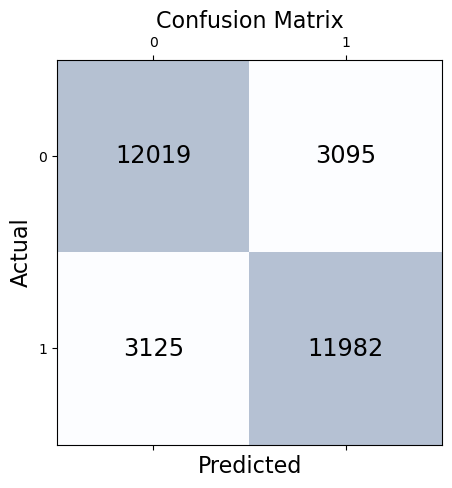

In [71]:
### Code from Anne van Duijvenbode, but slightly adjusted to fit the current data

## Random Forest for EO/ EC classification, sk learn Pipeline for StandardScaler().
## GroupKFold is a variation of KFold that makes sure that predefined underlying groups (here: participants) 
## in the data do not appear in both train and test set in the same fold. 

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing

## Prevent warning printing
import warnings
warnings.filterwarnings("ignore")

## Set random seed
random_seed  = 333

## Assign numeric columns
numeric_cols = []
for band in bands:
    for group in channel_groups:
        numeric_cols.append(f'{group}_{band}')


## Assign groups for GroupKFold
groups = np.array(df_unprocessed['ID'].values)

## Specify cross-validation iterator 
gkf = GroupKFold(5)

## Specify classifier
rf = RandomForestClassifier()

## Get features and target arrays
def get_features_and_target_arrays(df, numeric_cols):
    x_numeric_scaled = df[numeric_cols]
#     x_categorical = df[cat_cols].to_numpy()
#     X = np.hstack((x_categorical, x_numeric_scaled))
    X = x_numeric_scaled
    y = df['EO/EC'].values
    return X, y

## X and y
X, y = get_features_and_target_arrays(df_unprocessed, numeric_cols)

## Make Pipeline
classifier_pipeline = make_pipeline(preprocessing.StandardScaler(), rf)

## Print splits
for split, (ix_train, ix_test) in enumerate(gkf.split(X, groups=groups)):
    
    print(f'SPLIT {split+1}')
    print(f'TRAIN INDEXES: {ix_train}, TEST INDEXES: {ix_test}\n')
    print(f'Length train: {len(ix_train)}, Length test: {len(ix_test)}\n')


## Define scores
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
## CrossValidation scores
cv_scores = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = 'accuracy')
cv_scores_f1 = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(f1_score))
cv_scores_recall = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(recall_score))
cv_scores_precision = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(precision_score))

## Print CrossValidation scores per fold (accuracy and f1)
print('cv_scores mean acc:{}'.format(np.mean(cv_scores)))
print()
print('cv_scores std acc:{}'.format(np.std(cv_scores)))
print()
print('cv_scores acc:', cv_scores)
print()
print('cv_scores mean f1:{}'.format(np.mean(cv_scores_f1)))
print()
print('cv_scores std f1:{}'.format(np.std(cv_scores_f1)))
print()
print('cv_scores f1:', cv_scores_f1)

## Print CrossValidation scores (accuracy and f1)
print('cv_scores mean precision:{}'.format(np.mean(cv_scores_precision)))
print()
print('cv_scores std precision:{}'.format(np.std(cv_scores_precision)))
print()
print('cv_scores precision:', cv_scores_precision)
print()
print('cv_scores mean recall:{}'.format(np.mean(cv_scores_recall)))
print()
print('cv_scores std recall:{}'.format(np.std(cv_scores_recall)))
print()
print('cv_scores recall:', cv_scores_recall)

## Print F1-score and classification report
y_pred = cross_val_predict(classifier_pipeline, X, y,  cv = gkf, groups = groups)    
print('f1_score:', f1_score(y, y_pred))
print()
print('classification report:\n', classification_report(y, y_pred))

## Plot confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

Features sorted by their score for estimator 0:


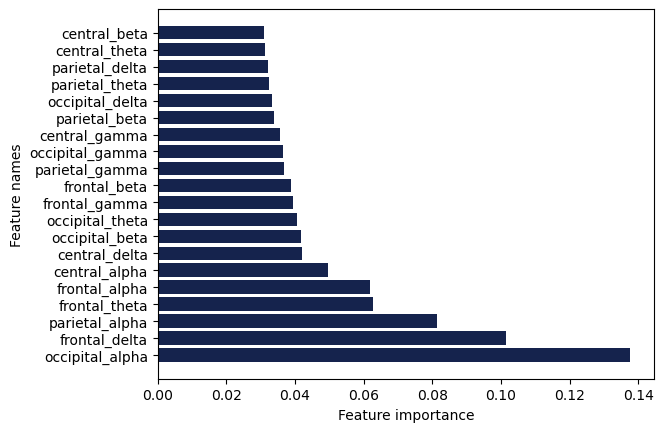

Features sorted by their score for estimator 1:


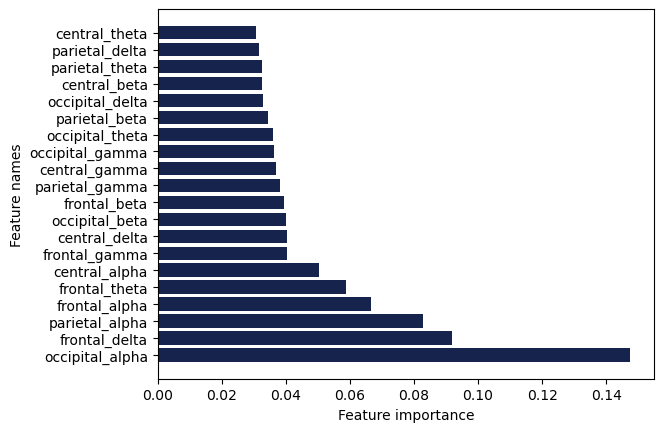

Features sorted by their score for estimator 2:


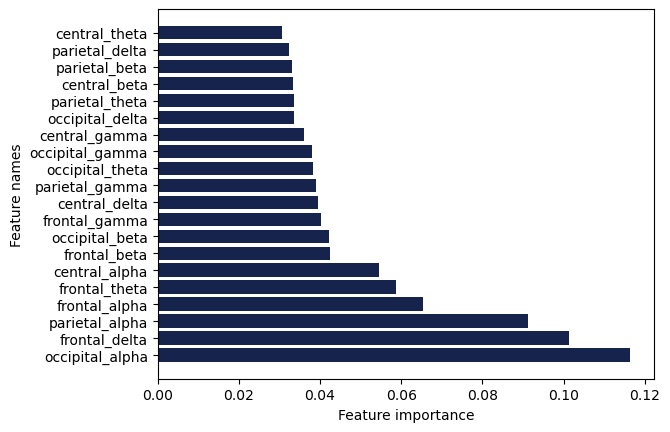

Features sorted by their score for estimator 3:


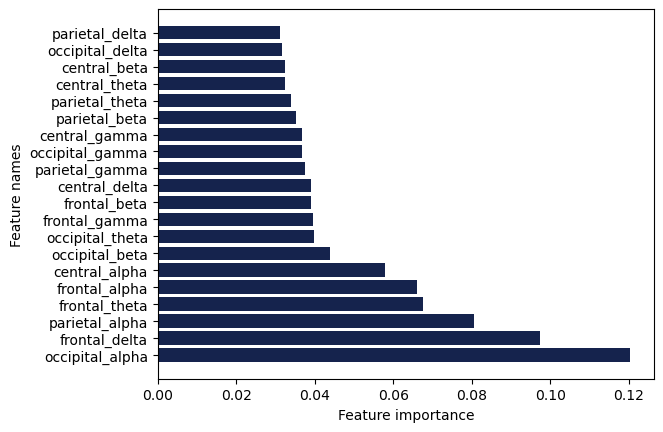

Features sorted by their score for estimator 4:


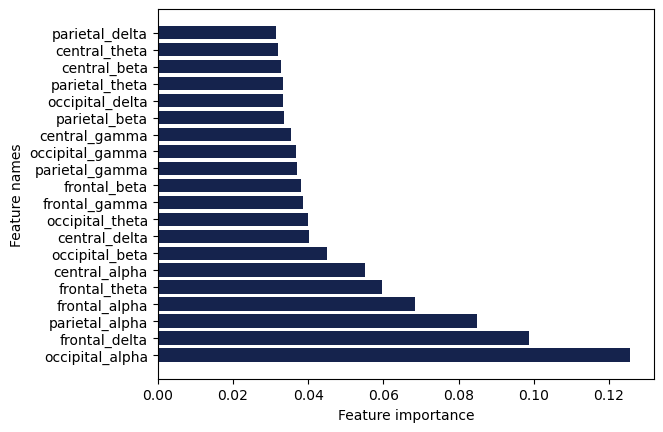

In [73]:
### Code from Anne van Duijvenbode, but slightly adjusted to fit the current data:

## Feature importance
output = cross_validate(classifier_pipeline, X, y, cv = gkf, scoring = 'accuracy', return_estimator = True, groups = groups)
feature_names = numeric_cols

## Get feature importances
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(list(zip(estimator[-1].feature_importances_, feature_names)),
                                       columns=['importance', 'feature_names']).sort_values('importance', ascending = False)
    #print(feature_importances)
    
    ## Plot feature importances
#     feature_importances.sort(key = lambda x : x[1])
    plt.barh(feature_importances['feature_names'], feature_importances['importance'], color = '#15234d')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')

    plt.show()

In [74]:
del df_unprocessed # remove dataframe from memory

### 2. Van Dijk's preprocessed data

In [84]:
df_vandijk = pd.read_pickle('df_vandijk_psds.pkl')

SPLIT 1
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   72    73    74 ... 30098 30099 30100]

Length train: 24174, Length test: 6047

SPLIT 2
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   48    49    50 ... 30194 30195 30196]

Length train: 24176, Length test: 6045

SPLIT 3
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   96    97    98 ... 30122 30123 30124]

Length train: 24176, Length test: 6045

SPLIT 4
TRAIN INDEXES: [   24    25    26 ... 30218 30219 30220], TEST INDEXES: [    0     1     2 ... 30146 30147 30148]

Length train: 24173, Length test: 6048

SPLIT 5
TRAIN INDEXES: [    0     1     2 ... 30194 30195 30196], TEST INDEXES: [   24    25    26 ... 30218 30219 30220]

Length train: 24185, Length test: 6036

cv_scores mean acc:0.751059159874572

cv_scores std acc:0.019112322742746

cv_scores acc: [0.73656359 0.74177006 0.77253929 0.77529762 0.72912525]

cv_scores mean f1:0.7549402883428037


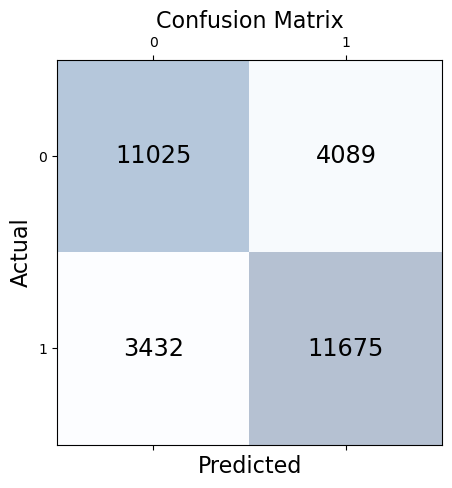

In [85]:
### Code from Anne van Duijvenbode, but slightly adjusted to fit the current data

## Random Forest for EO/ EC classification, sk learn Pipeline for StandardScaler().
## GroupKFold is a variation of KFold that makes sure that predefined underlying groups (here: participants) 
## in the data do not appear in both train and test set in the same fold. 

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing

## Prevent warning printing
import warnings
warnings.filterwarnings("ignore")

## Set random seed
random_seed  = 333

## Assign numeric columns
numeric_cols = []
for band in bands:
    for group in channel_groups:
        numeric_cols.append(f'{group}_{band}')


## Assign groups for GroupKFold
groups = np.array(df_vandijk['ID'].values)

## Specify cross-validation iterator 
gkf = GroupKFold(5)

## Specify classifier
rf = RandomForestClassifier()

## Get features and target arrays
def get_features_and_target_arrays(df, numeric_cols):
    x_numeric_scaled = df[numeric_cols]
#     x_categorical = df[cat_cols].to_numpy()
#     X = np.hstack((x_categorical, x_numeric_scaled))
    X = x_numeric_scaled
    y = df['EO/EC'].values
    return X, y

## X and y
X, y = get_features_and_target_arrays(df_vandijk, numeric_cols)

## Make Pipeline
classifier_pipeline = make_pipeline(preprocessing.StandardScaler(), rf)

## Print splits
for split, (ix_train, ix_test) in enumerate(gkf.split(X, groups=groups)):
    
    print(f'SPLIT {split+1}')
    print(f'TRAIN INDEXES: {ix_train}, TEST INDEXES: {ix_test}\n')
    print(f'Length train: {len(ix_train)}, Length test: {len(ix_test)}\n')


## Define scores
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
## CrossValidation scores
cv_scores = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = 'accuracy')
cv_scores_f1 = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(f1_score))
cv_scores_recall = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(recall_score))
cv_scores_precision = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(precision_score))

## Print CrossValidation scores per fold (accuracy and f1)
print('cv_scores mean acc:{}'.format(np.mean(cv_scores)))
print()
print('cv_scores std acc:{}'.format(np.std(cv_scores)))
print()
print('cv_scores acc:', cv_scores)
print()
print('cv_scores mean f1:{}'.format(np.mean(cv_scores_f1)))
print()
print('cv_scores std f1:{}'.format(np.std(cv_scores_f1)))
print()
print('cv_scores f1:', cv_scores_f1)

## Print CrossValidation scores (accuracy and f1)
print('cv_scores mean precision:{}'.format(np.mean(cv_scores_precision)))
print()
print('cv_scores std precision:{}'.format(np.std(cv_scores_precision)))
print()
print('cv_scores precision:', cv_scores_precision)
print()
print('cv_scores mean recall:{}'.format(np.mean(cv_scores_recall)))
print()
print('cv_scores std recall:{}'.format(np.std(cv_scores_recall)))
print()
print('cv_scores recall:', cv_scores_recall)

## Print F1-score and classification report
y_pred = cross_val_predict(classifier_pipeline, X, y,  cv = gkf, groups = groups)    
print('f1_score:', f1_score(y, y_pred))
print()
print('classification report:\n', classification_report(y, y_pred))

## Plot confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

Features sorted by their score for estimator 0:


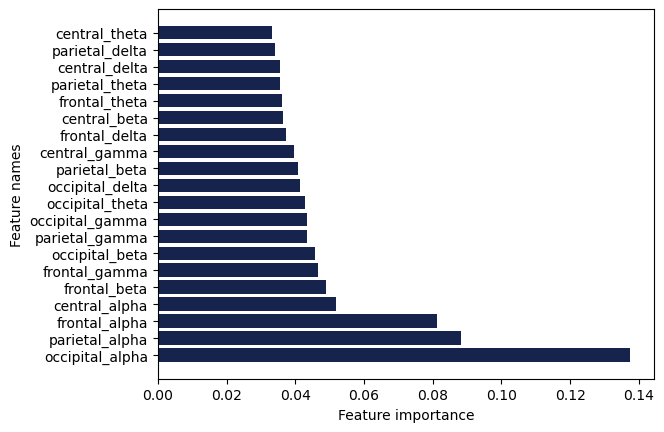

Features sorted by their score for estimator 1:


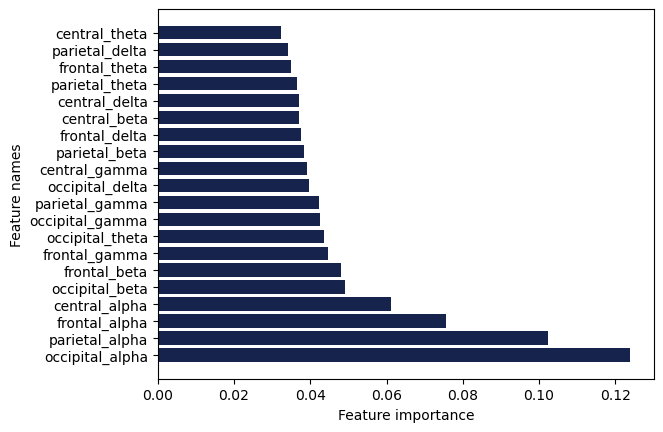

Features sorted by their score for estimator 2:


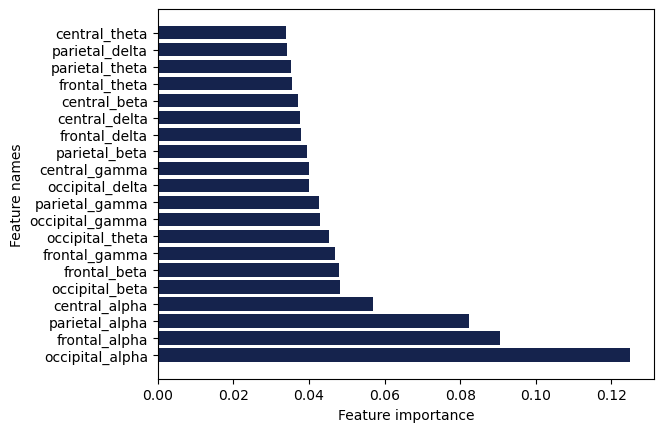

Features sorted by their score for estimator 3:


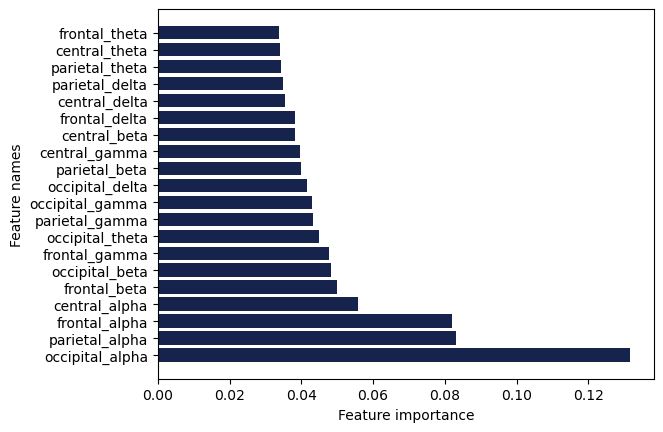

Features sorted by their score for estimator 4:


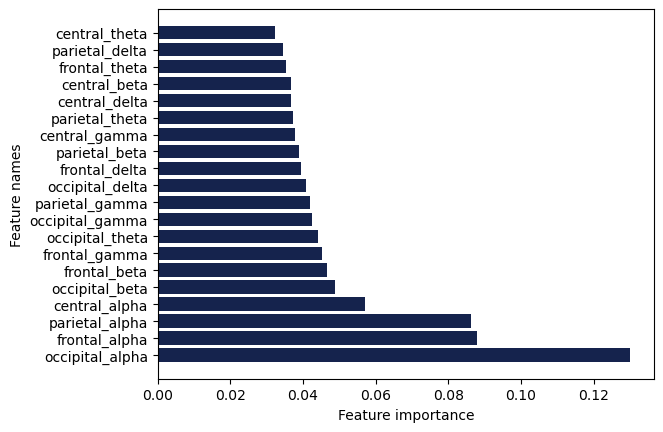

In [86]:
### Code from Anne van Duijvenbode, but slightly adjusted to fit the current data:

## Feature importance
output = cross_validate(classifier_pipeline, X, y, cv = gkf, scoring = 'accuracy', return_estimator = True, groups = groups)
feature_names = numeric_cols

## Get feature importances
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(list(zip(estimator[-1].feature_importances_, feature_names)),
                                       columns=['importance', 'feature_names']).sort_values('importance', ascending = False)
    #print(feature_importances)
    
    ## Plot feature importances
#     feature_importances.sort(key = lambda x : x[1])
    plt.barh(feature_importances['feature_names'], feature_importances['importance'], color = '#15234d')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')

    plt.show()

In [87]:
del df_vandijk # remove dataframe from memory

### 3. Own preprocessed data

In [15]:
df_own = pd.read_pickle('df_own_psds.pkl')
df_own.head(3)

,ID,EO/EC,epoch,frontal_delta,central_delta,parietal_delta,occipital_delta,frontal_theta,central_theta,parietal_theta,...,parietal_alpha,occipital_alpha,frontal_beta,central_beta,parietal_beta,occipital_beta,frontal_gamma,central_gamma,parietal_gamma,occipital_gamma
0,sub-19681349,0,1,0.022361,0.026038,0.015899,0.002731,0.007431,0.010366,0.008129,...,0.013591,0.005354,0.006169,0.011186,0.008208,0.002882,0.002588,0.004813,0.002902,0.000814
1,sub-19681349,0,2,0.016637,0.018218,0.013514,0.003852,0.008221,0.006257,0.008458,...,0.015985,0.006479,0.006510,0.013021,0.009358,0.002709,0.002112,0.003831,0.002605,0.000596
2,sub-19681349,0,3,0.024904,0.030129,0.017448,0.005419,0.008517,0.011562,0.011829,...,0.018971,0.005862,0.005305,0.009682,0.007877,0.002781,0.002323,0.004190,0.002658,0.000655


SPLIT 1
TRAIN INDEXES: [   24    25    26 ... 30218 30219 30220], TEST INDEXES: [    0     1     2 ... 30146 30147 30148]

Length train: 24188, Length test: 6033

SPLIT 2
TRAIN INDEXES: [    0     1     2 ... 30146 30147 30148], TEST INDEXES: [  120   121   122 ... 30218 30219 30220]

Length train: 24173, Length test: 6048

SPLIT 3
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   24    25    26 ... 30074 30075 30076]

Length train: 24173, Length test: 6048

SPLIT 4
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   48    49    50 ... 30098 30099 30100]

Length train: 24174, Length test: 6047

SPLIT 5
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   72    73    74 ... 30122 30123 30124]

Length train: 24176, Length test: 6045

cv_scores mean acc:0.6889180614248167

cv_scores std acc:0.009264970678263271

cv_scores acc: [0.67313111 0.68568122 0.69047619 0.70034728 0.69495451]

cv_scores mean f1:0.6875567895748

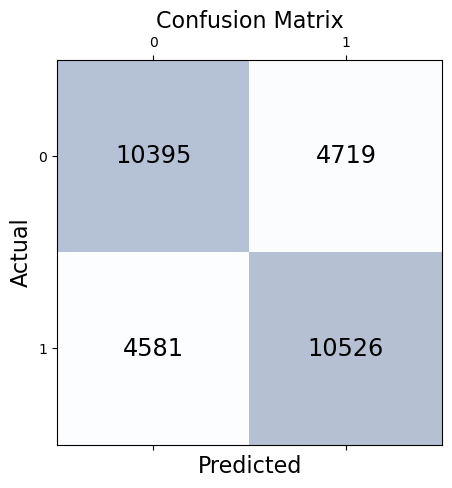

In [16]:
### Code from Anne van Duijvenbode, but slightly adjusted to fit the current data

## Random Forest for EO/ EC classification, sk learn Pipeline for StandardScaler().
## GroupKFold is a variation of KFold that makes sure that predefined underlying groups (here: participants) 
## in the data do not appear in both train and test set in the same fold. 

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing

## Prevent warning printing
import warnings
warnings.filterwarnings("ignore")

## Set random seed
random_seed  = 333

## Assign numeric columns
numeric_cols = []
for band in bands:
    for group in channel_groups:
        numeric_cols.append(f'{group}_{band}')


## Assign groups for GroupKFold
groups = np.array(df_own['ID'].values)

## Specify cross-validation iterator 
gkf = GroupKFold(5)

## Specify classifier
rf = RandomForestClassifier()

## Get features and target arrays
def get_features_and_target_arrays(df, numeric_cols):
    x_numeric_scaled = df[numeric_cols]
#     x_categorical = df[cat_cols].to_numpy()
#     X = np.hstack((x_categorical, x_numeric_scaled))
    X = x_numeric_scaled
    y = df['EO/EC'].values
    return X, y

## X and y
X, y = get_features_and_target_arrays(df_own, numeric_cols)

## Make Pipeline
classifier_pipeline = make_pipeline(preprocessing.StandardScaler(), rf)

## Print splits
for split, (ix_train, ix_test) in enumerate(gkf.split(X, groups=groups)):
    
    print(f'SPLIT {split+1}')
    print(f'TRAIN INDEXES: {ix_train}, TEST INDEXES: {ix_test}\n')
    print(f'Length train: {len(ix_train)}, Length test: {len(ix_test)}\n')


## Define scores
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
## CrossValidation scores
cv_scores = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = 'accuracy')
cv_scores_f1 = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(f1_score))
cv_scores_recall = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(recall_score))
cv_scores_precision = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(precision_score))

## Print CrossValidation scores per fold (accuracy and f1)
print('cv_scores mean acc:{}'.format(np.mean(cv_scores)))
print()
print('cv_scores std acc:{}'.format(np.std(cv_scores)))
print()
print('cv_scores acc:', cv_scores)
print()
print('cv_scores mean f1:{}'.format(np.mean(cv_scores_f1)))
print()
print('cv_scores std f1:{}'.format(np.std(cv_scores_f1)))
print()
print('cv_scores f1:', cv_scores_f1)

## Print CrossValidation scores (accuracy and f1)
print('cv_scores mean precision:{}'.format(np.mean(cv_scores_precision)))
print()
print('cv_scores std precision:{}'.format(np.std(cv_scores_precision)))
print()
print('cv_scores precision:', cv_scores_precision)
print()
print('cv_scores mean recall:{}'.format(np.mean(cv_scores_recall)))
print()
print('cv_scores std recall:{}'.format(np.std(cv_scores_recall)))
print()
print('cv_scores recall:', cv_scores_recall)

## Print F1-score and classification report
y_pred = cross_val_predict(classifier_pipeline, X, y,  cv = gkf, groups = groups)    
print('f1_score:', f1_score(y, y_pred))
print()
print('classification report:\n', classification_report(y, y_pred))

## Plot confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

Features sorted by their score for estimator 0:


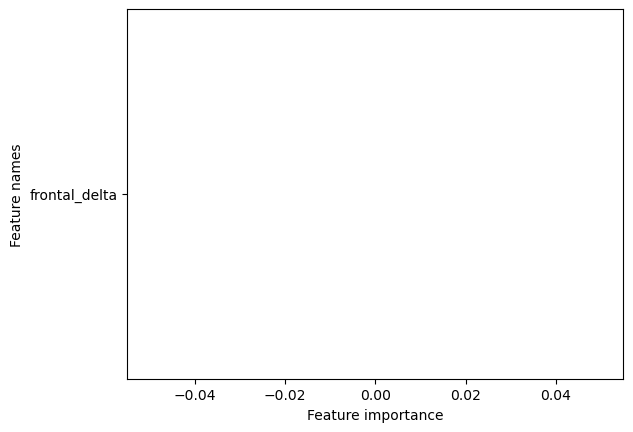

Features sorted by their score for estimator 1:


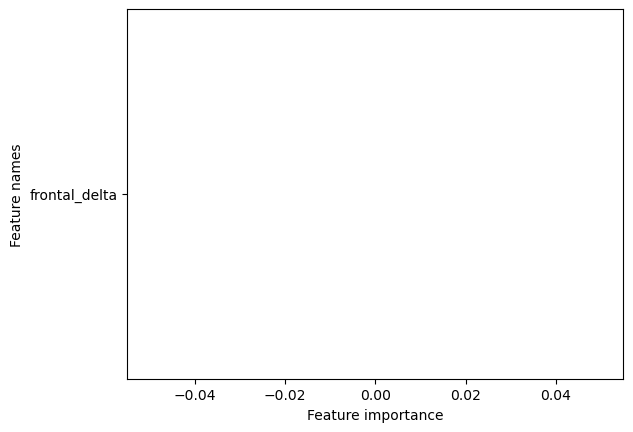

Features sorted by their score for estimator 2:


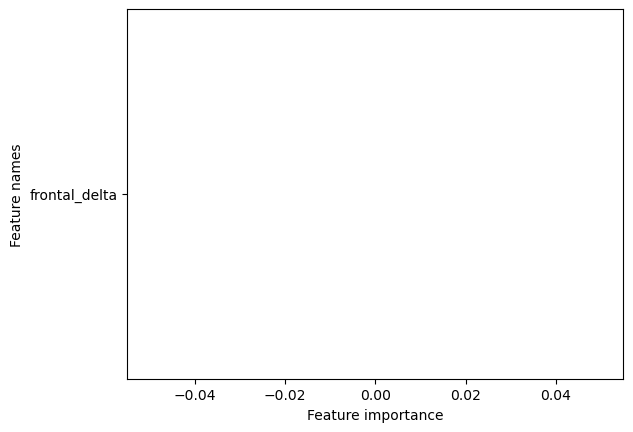

Features sorted by their score for estimator 3:


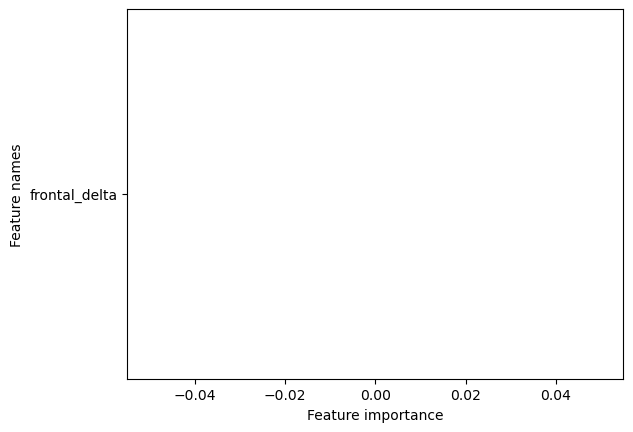

Features sorted by their score for estimator 4:


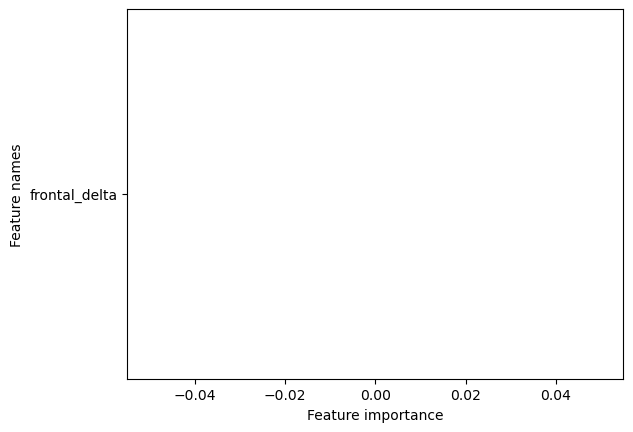

In [17]:
### Code from Anne van Duijvenbode, but slightly adjusted to fit the current data:

## Feature importance
output = cross_validate(classifier_pipeline, X, y, cv = gkf, scoring = 'accuracy', return_estimator = True, groups = groups)
feature_names = numeric_cols

## Get feature importances
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(list(zip(estimator[-1].feature_importances_, feature_names)),
                                       columns=['importance', 'feature_names']).sort_values('importance', ascending = False)
    #print(feature_importances)
    
    ## Plot feature importances
#     feature_importances.sort(key = lambda x : x[1])
    plt.barh(feature_importances['feature_names'], feature_importances['importance'], color = '#15234d')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')

    plt.show()

In [ ]:
del df_own # remove dataframe from memory